# Zeitbezogene Analysen / Lokalität / Studiengang 4

Das studentische Verhalten wird nachfolgend hinsichtlich seines zeitlichen Auftretens betrachtet.

**Zeitraum der aufgezeichneten Log-Einträge**
Montag, 12.10.2020 bis Donnerstag, 03.06.2021
Länge des Zeitraums: 7 Monate, 3 Wochen, 2 Tage
Länge in Tagen: 235 Tage
Länge in Wochen: 33 Wochen, 4 Tage

**Prüfungszeitraum 1**
Freitag, 22.01.2021 bis Samstag, 06.02.2021
Länge in Tagen: 16 Tage (inkl. Sonntage)

**Prüfungszeitraum 2**
Freitag, 12.03.2021 bis Samstag, 27.03.2021
Länge in Tagen: 16 Tage (inkl. Sonntage)

### Import von Bibliotheken und anderen Erweiterungen

In [1]:
from sqlalchemy import create_engine
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import ticker as ticker
from matplotlib import patches as mpatches
import seaborn as sns
from IPython.core.display_functions import display

### Definitionen zur Darstellung der Visualisierungen

In [2]:
sns.set_theme(style='white', font_scale=1.2, palette='Set2_r')

# Definition von Farblisten (Brewer-Palettes)
colors_set3 = ['#8dd3c7', '#ffffb3', '#bebada', '#fb8072', '#80b1d3', '#fdb462', '#b3de69', '#fccde5', '#d9d9d9', '#bc80bd', '#ccebc5', '#ffed6f']
colors_set2 = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854', '#ffd92f', '#e5c494', '#b3b3b3']

# Definition von Farben für die Studiengänge
colors_studies = ['#dac29e', '#e5c94a', '#a2c865', '#da96bf', '#94a3c2']

# Ausgabe der Ergebnistabellen in ungekürzter Form
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

### Herstellung der Verbindung zur MySQL-Datenbank

In [3]:
user = "root"
password = "root"
host = "localhost"
database = "vfh_moodle_ws20"
port = 3306

engine = create_engine(f'mysql+pymysql://{user}:{password}@{host}/{database}', pool_recycle=port)
connection = engine.connect()

### Import der Arbeitsdaten aus der MySQL-Datenbank

In [4]:
# Gegenstand der Untersuchungen sind nur Datensätze von zuvor als Studenten identifizierten Benutzern – unabhängig davon,
# ob diese selbst eine Aktivität initiiert haben oder nur mit einer Aktivität einer anderen Person in Beziehung standen.
query = """SELECT * FROM moodle_data WHERE userstatus = 'student' OR relateduserstatus = 'student'"""
md = pd.read_sql(query, connection) # Definition der Arbeitsdaten

### Vorbereitung der Arbeitsdaten

In [5]:
# Konvertierung des Datentyps des Tabellenmerkmals timecreated
md['timecreated'] = pd.to_datetime(md['timecreated'], unit='s')

# Ergänzung des Merkmals 'behaviour' zur Unterscheidung von Lern- und Kommunikationsverhalten
md['behaviour'] = 'other'
md.loc[(md.eventname == r'\core\event\course_viewed'), ['behaviour']] = 'learning'
md.loc[(md.eventname == r'\mod_resource\event\course_module_viewed'), ['behaviour']] = 'learning'
md.loc[(md.eventname == r'\mod_assign\event\course_module_viewed'), ['behaviour']] = 'learning'
md.loc[(md.eventname == r'\mod_quiz\event\attempt_viewed'), ['behaviour']] = 'learning'
md.loc[(md.eventname == r'\mod_url\event\course_module_viewed'), ['behaviour']] = 'learning'
md.loc[(md.eventname == r'\mod_quiz\event\course_module_viewed'), ['behaviour']] = 'learning'
md.loc[(md.eventname == r'\mod_page\event\course_module_viewed'), ['behaviour']] = 'learning'
md.loc[(md.eventname == r'\mod_wiki\event\course_module_viewed'), ['behaviour']] = 'learning'
md.loc[(md.eventname == r'\mod_wiki\event\page_viewed'), ['behaviour']] = 'learning'
md.loc[(md.eventname == r'\mod_choice\event\course_module_viewed'), ['behaviour']] = 'learning'
md.loc[(md.eventname == r'\mod_folder\event\course_module_viewed'), ['behaviour']] = 'learning'
md.loc[(md.eventname == r'\mod_glossary\event\course_module_viewed'), ['behaviour']] = 'learning'
md.loc[(md.eventname == r'\mod_workshop\event\course_module_viewed'), ['behaviour']] = 'learning'
md.loc[(md.eventname == r'\mod_bigbluebuttonbn\event\recording_viewed'), ['behaviour']] = 'learning'
md.loc[(md.eventname == r'\mod_forum\event\course_module_viewed'), ['behaviour']] = 'communication'
md.loc[(md.eventname == r'\mod_forum\event\discussion_viewed'), ['behaviour']] = 'communication'
md.loc[(md.eventname == r'\core\event\message_viewed'), ['behaviour']] = 'communication'
md.loc[(md.eventname == r'\mod_chat\event\course_module_viewed'), ['behaviour']] = 'communication'
md.loc[(md.eventname == r'\mod_chat\event\sessions_viewed'), ['behaviour']] = 'communication'

# Ergänzung von Merkmalen zur Betrachtung weiterer zeitlicher Aspekte
md['year_month'] = md.timecreated.dt.strftime('%Y-%m')
md['year_week'] = md.timecreated.dt.strftime('%Y-%U')
md['year_day'] = md.timecreated.dt.dayofyear
md['dayname'] = md.timecreated.dt.day_name()

# Ergänzung von Merkmalen zur Unterscheidung von Arbeitstagen und Wochenenden
md['daytype'] = 'workingday'
md.loc[md.timecreated.dt.dayofweek > 4, ['daytype']] = 'weekend'

# Ergänzung von Merkmalen zur Unterscheidung von Tageszeiten
md['daytime_1'] = 'freetime'
md.loc[(md.timecreated.dt.hour >= 9) & (md.timecreated.dt.hour < 18), ['daytime_1']] = 'workingtime'
md['daytime_2'] = 'night'
md.loc[(md.timecreated.dt.hour >= 6) & (md.timecreated.dt.hour < 14), ['daytime_2']] = 'morning'
md.loc[(md.timecreated.dt.hour >= 14) & (md.timecreated.dt.hour < 18), ['daytime_2']] = 'afternoon'
md.loc[(md.timecreated.dt.hour >= 18) & (md.timecreated.dt.hour < 22), ['daytime_2']] = 'evening'

# Definition der Arbeitsdaten
md = md[(md.Studiengang == '4') & ((md['behaviour'] == 'learning') | (md['behaviour'] == 'communication'))]

# Ausgabe der Arbeitsdaten
md

courseid Studiengang  userid userstatus  relateduserid  \
1368       27583           4       1    student              0   
1369       27583           4       1    student              0   
1370       27583           4       1    student              0   
1371       27583           4       1    student              0   
1372       27583           4       1    student              0   
1373       27583           4       1    student              0   
1374       27583           4       1    student              0   
1377       27583           4       1    student              0   
1380       27583           4       1    student              0   
1383       27583           4       1    student              0   
1447       27637           4       1    student              0   
1448       27637           4       1    student              0   
1450       27637           4       1    student              0   
1451       27637           4       1    student              0   
1452       27637           4       1    student              0   
1453       27583           4       1    student              0   
1454       27583           4       1    student              0   
1455       27583           4       1    student              0   
1456       27583           4       1    student              0   
1457       27583           4       1    student              0   
1458       27583           4       1    student              0   
1459       27583           4       1    student              0   
1468       27583           4       1    student              0   
1469       27583           4       1    student              0   
1470       27583           4       1    student              0   
1471       27583           4       1    student              0   
1472       27583           4       1    student              0   
1473       27583           4       1    student              0   
1474       27583           4       1    student              0   
1475       27583           4       1    student              0   
1477       27583           4       1    student              0   
1478       27583           4       1    student              0   
1479       27583           4       1    student              0   
1481       27583           4       1    student              0   
1482       27583           4       1    student              0   
1483       27583           4       1    student              0   
1484       27583           4       1    student              0   
1485       27583           4       1    student              0   
1486       27583           4       1    student              0   
1488       27637           4       1    student              0   
1489       27637           4       1    student              0   
1491       27637           4       1    student              0   
1492       27637           4       1    student              0   
1493       27637           4       1    student              0   
1494       27637           4       1    student              0   
1495       27637           4       1    student              0   
1497       27637           4       1    student              0   
1498       27637           4       1    student              0   
1500       27637           4       1    student              0   
1501       27637           4       1    student              0   
1503       27637           4       1    student              0   
1506       27637           4       1    student              0   
1507       27583           4       1    student              0   
1508       27583           4       1    student              0   
1509       27583           4       1    student              0   
1512       27583           4       1    student              0   
1515       27583           4       1    student              0   
1516       27583           4       1    student              0   
1519       27583           4       1    student              0   
1520       27583           4       1    student 

&nbsp;
#### Wochentag pro Log-Eintrag

In [6]:
# Ausgabe der Wochentage der protokollierten Log-Einträge
days_per_week = md.timecreated.dt.dayofweek.sort_values()
# display(days_per_week)

&nbsp;
#### Tagesstunde pro Log-Eintrag

In [7]:
# Ausgabe der Tagesstunden der protokollierten Log-Einträge
hours_per_day = md.timecreated.dt.hour.sort_values()
# display(hours_per_day)

### Betrachtung des Lern- und Kommunikationsverhaltens

&nbsp;
**Verteilung der Log-Einträge im Gesamtzeitraum**

In [8]:
# Ausgabe statistischer Werte für das Tabellenmerkmal timecreated
display(md.timecreated.describe(datetime_is_numeric=True))  # Daten müssen für diese Ausgabe als datetime typisiert sein.

count                             3138
mean     2021-01-30 10:21:45.288081408
min                2020-10-12 03:55:03
25%      2020-11-26 19:23:09.249999872
50%                2021-02-01 17:03:47
75%                2021-03-24 20:45:03
max                2021-06-02 18:16:23
Name: timecreated, dtype: object

&nbsp;
#### Menge der Log-Einträge pro Woche

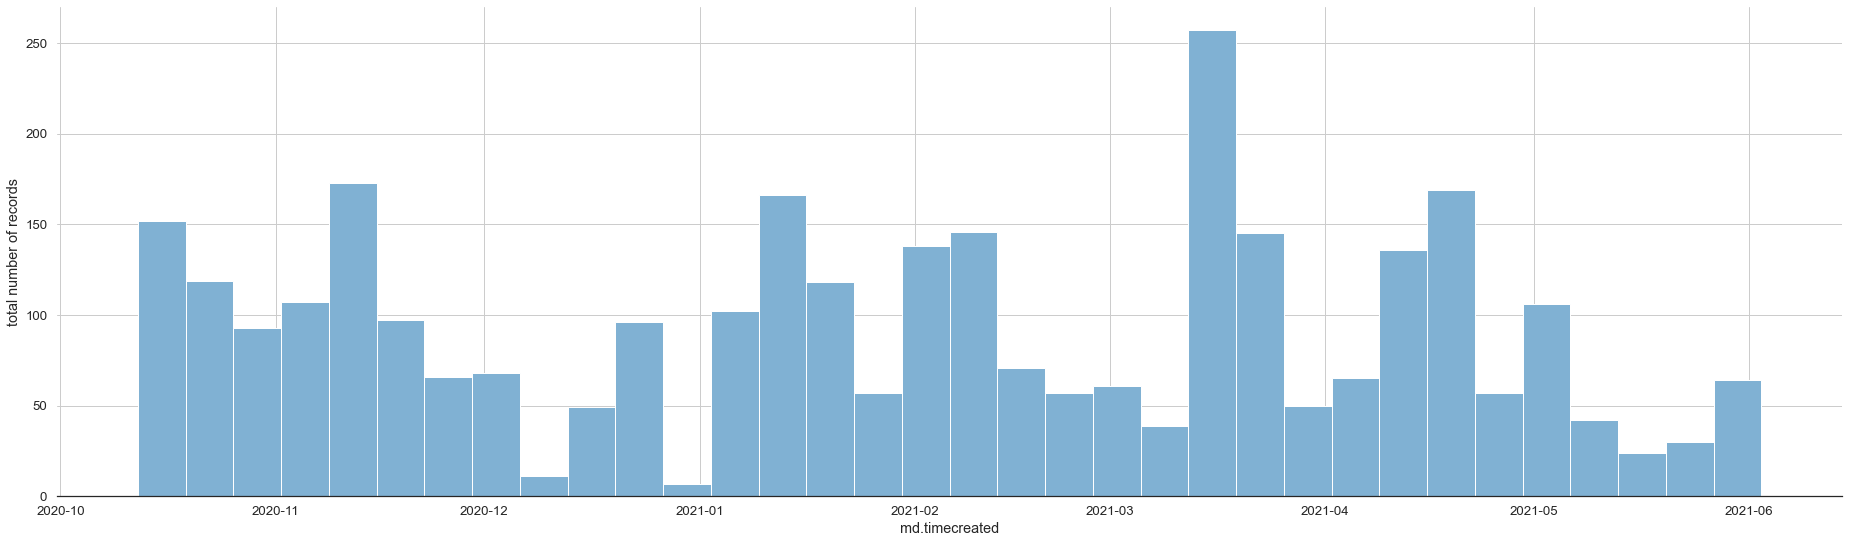

In [9]:
# Spezifische Definitionen zur Darstellung der Visualisierung
plt.figure(figsize=(32, 9)) # Größe der Visualisierung (in inch)

# Visualisierung der Menge der Log-Einträge über 8 Monate (Gesamtzeitraum)
# chart = sns.histplot(data=md.timecreated, bins=8, color=colors_set3[4], alpha=1)

# Visualisierung der Menge der Log-Einträge über 34 Wochen (Gesamtzeitraum)
chart = sns.histplot(data=md.timecreated, bins=34, color=colors_set3[4], alpha=1)

# Visualisierung der Menge der Log-Einträge über 235 Tage (Gesamtzeitraum)
# chart = sns.histplot(data=md.timecreated, bins=235, color=colors_set3[4], alpha=1)

# weitere Anweisungen zur Darstellung der Visualisierung
chart.grid(axis='both')
chart.set_axisbelow(True)
chart.set_xlabel('md.timecreated')
chart.set_ylabel('total number of records')
chart.tick_params(left=False, bottom=False)
sns.despine(left=True)
plt.savefig('charts/Analyse_der_Lokalitaet_Log-Eintraege_pro_Woche.pdf', format='pdf')
plt.show()

&nbsp;
#### Menge der Log-Einträge pro Tag

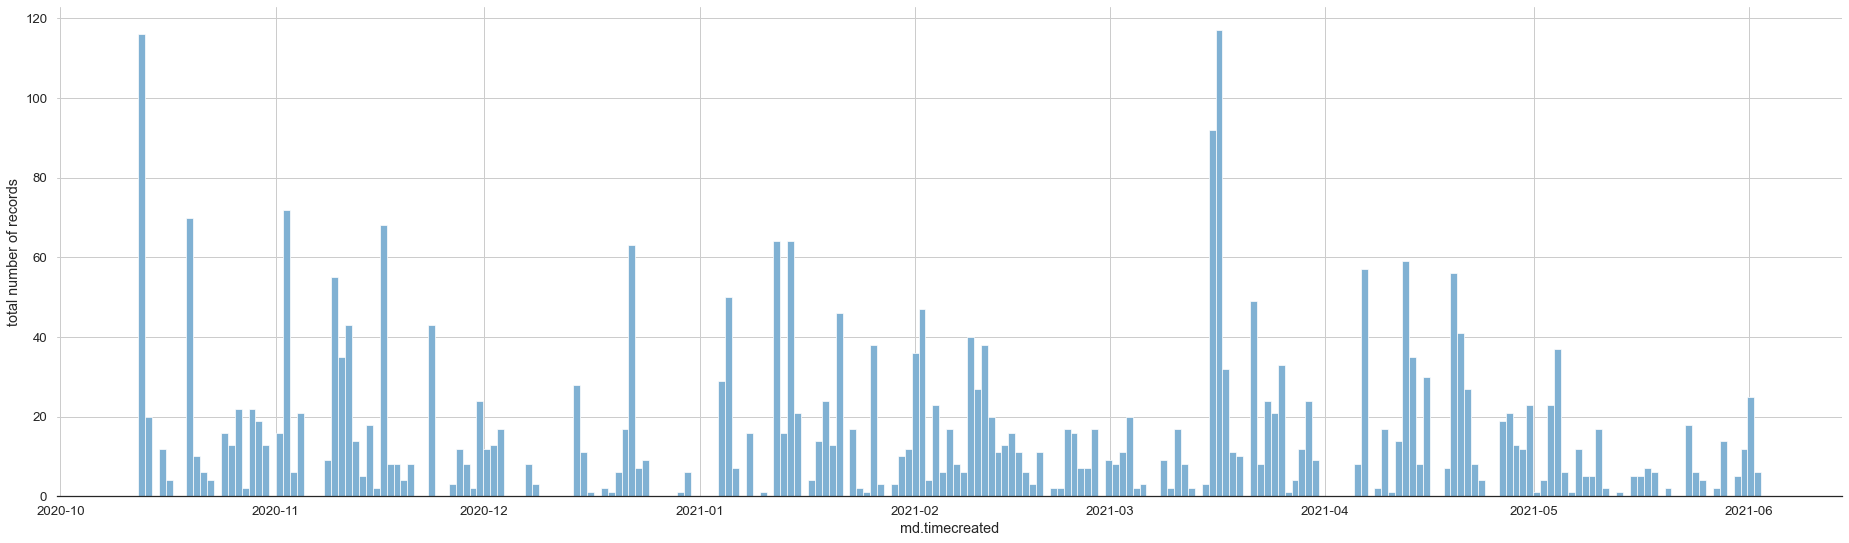

In [10]:
# Spezifische Definitionen zur Darstellung der Visualisierung
plt.figure(figsize=(32, 9)) # Größe der Visualisierung (in inch)

# Visualisierung der Menge der Log-Einträge über 8 Monate (Gesamtzeitraum)
# chart = sns.histplot(data=md.timecreated, bins=8, color=colors_set3[4], alpha=1)

# Visualisierung der Menge der Log-Einträge über 34 Wochen (Gesamtzeitraum)
# chart = sns.histplot(data=md.timecreated, bins=34, color=colors_set3[4], alpha=1)

# Visualisierung der Menge der Log-Einträge über 235 Tage (Gesamtzeitraum)
chart = sns.histplot(data=md.timecreated, bins=235, color=colors_set3[4], alpha=1)

# weitere Anweisungen zur Darstellung der Visualisierung
chart.grid(axis='both')
chart.set_axisbelow(True)
chart.set_xlabel('md.timecreated')
chart.set_ylabel('total number of records')
chart.tick_params(left=False, bottom=False)
sns.despine(left=True)
plt.savefig('charts/Analyse_der_Lokalitaet_Log-Eintraege_pro_Tag.pdf', format='pdf')
plt.show()

&nbsp;
#### Menge der Log-Einträge pro Wochentag

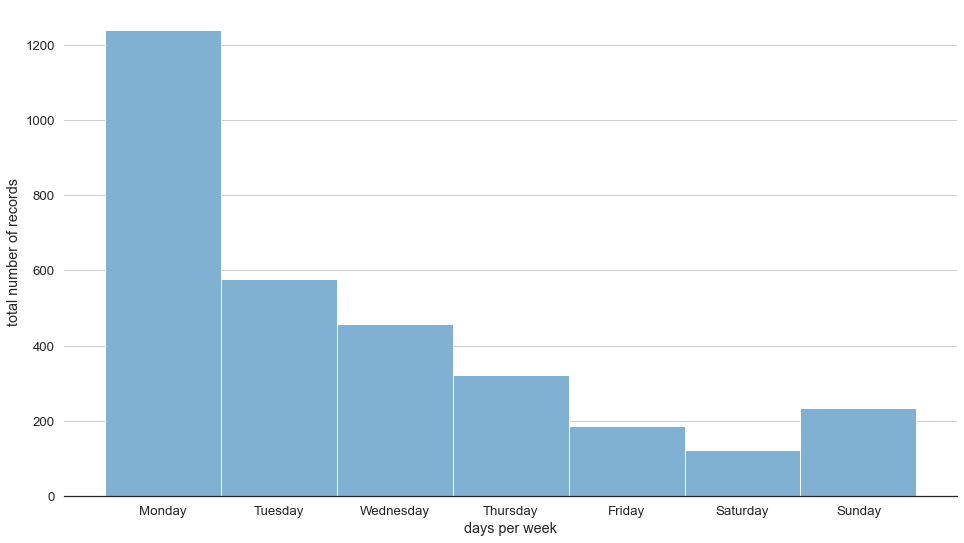

In [11]:
# Spezifische Definitionen zur Darstellung der Visualisierung
plt.figure(figsize=(16, 9)) # Größe der Visualisierung (in inch)

# Visualisierung der Menge der Log-Einträge pro Wochentag
chart = sns.histplot(days_per_week, bins=7, discrete=True, color=colors_set3[4], alpha=1)

# weitere Anweisungen zur Darstellung der Visualisierung
chart.grid(axis='y')
chart.set_axisbelow(True)
chart.xaxis.set_ticks(range(0, 7, 1))
chart.set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
chart.set_xlabel('days per week')
chart.set_ylabel('total number of records')
chart.tick_params(left=False, bottom=False)
sns.despine(left=True)
# plt.savefig('charts/###.pdf', format='pdf')
plt.show()

&nbsp;
**Verteilung der Log-Einträge über die Wochentage**

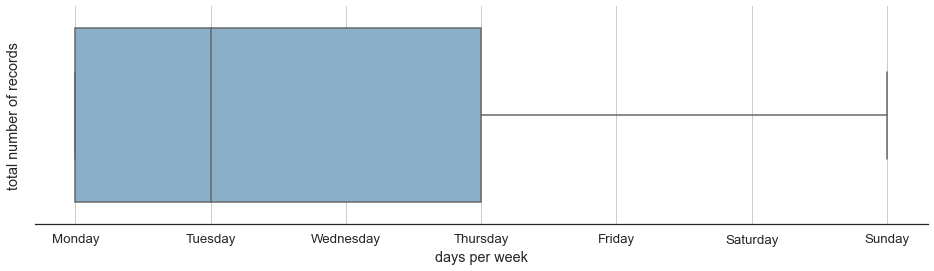

In [12]:
# Spezifische Definitionen zur Darstellung der Visualisierung
plt.figure(figsize=(16, 4))  # Größe der Visualisierung (in inch)

# Visualisierung der Verteilung der Log-Einträge über die Wochentage
chart = sns.boxplot(x=days_per_week, orient='h', color=colors_set3[4])

# weitere Anweisungen zur Darstellung der Visualisierung
chart.grid(axis='x')
chart.xaxis.set_ticks(range(0, 7, 1))
chart.set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
chart.set_xlabel('days per week')
chart.set_ylabel('total number of records')
sns.despine(left=True)
# plt.savefig('charts/###.pdf', format='pdf')
plt.show()

&nbsp;
#### Menge der Log-Einträge pro Tagesstunde

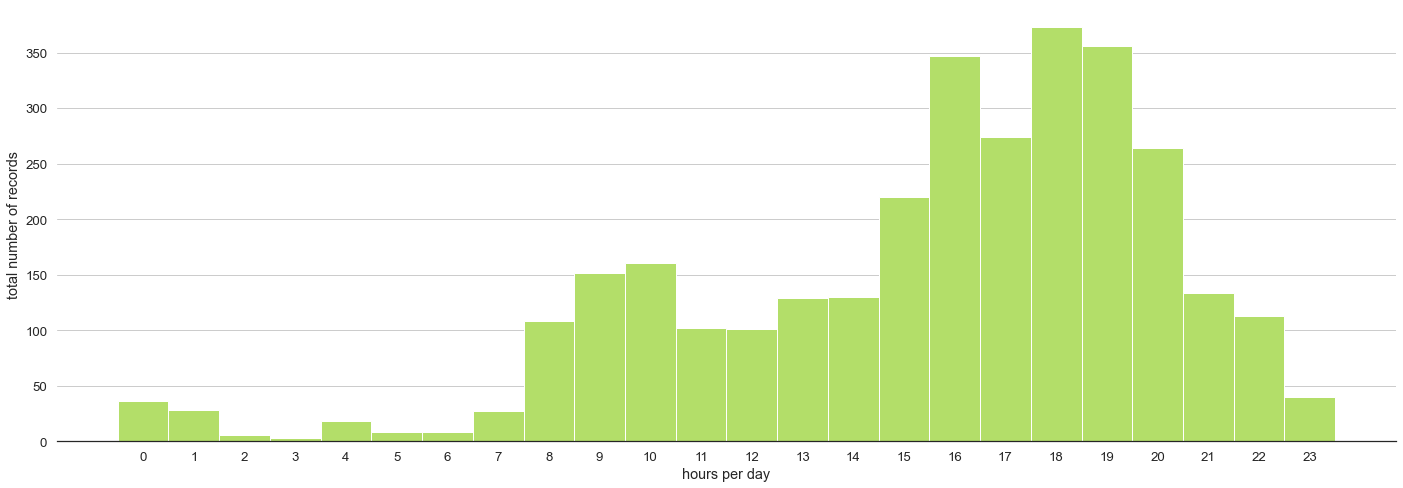

In [13]:
# Spezifische Definitionen zur Darstellung der Visualisierung
plt.figure(figsize=(24, 8)) # Größe der Visualisierung (in inch)

# Visualisierung der Menge der Log-Einträge pro Tagesstunde
chart = sns.histplot(hours_per_day, bins=24, discrete=True, color=colors_set3[6], alpha=1)

# weitere Anweisungen zur Darstellung der Visualisierung
chart.grid(axis='y')
chart.set_axisbelow(True)
chart.xaxis.set_ticks(range(0, 24, 1))
chart.set_xlabel('hours per day')
chart.set_ylabel('total number of records')
chart.tick_params(left=False, bottom=False)
sns.despine(left=True)
# plt.savefig('charts/###.pdf', format='pdf')
plt.show()

&nbsp;
**Verteilung der Log-Einträge über die Tagesstunden**

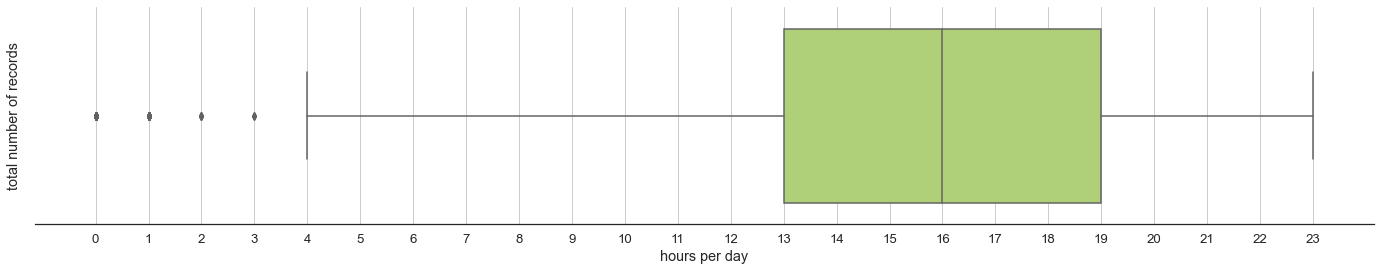

In [14]:
# Spezifische Definitionen zur Darstellung der Visualisierung
plt.figure(figsize=(24, 4))  # Größe der Visualisierung (in inch)

# Visualisierung der Verteilung der Log-Einträge über die Tagesstunden
chart = sns.boxplot(x=hours_per_day, orient='h', color=colors_set3[6])

# weitere Anweisungen zur Darstellung der Visualisierung
chart.grid(axis='x')
chart.xaxis.set_ticks(range(0, 24, 1))
chart.set_xlabel('hours per day')
chart.set_ylabel('total number of records')
sns.despine(left=True)
# plt.savefig('charts/###.pdf', format='pdf')
plt.show()

&nbsp;
#### Ermittlung der Unterscheidungskriterien

&nbsp;
**Erstellung des neuen Datensets _loggings_daytype_ zur Aufnahme individueller Kennziffern**

In [15]:
# Erstellung eines neuen Datensets, bestehend aus den anteiligen Mengen an Log-Einträgen pro Student und Tagestyp
loggings_daytype = pd.DataFrame()
loggings_daytype['loggings'] = md.timecreated[md.userstatus == 'student'].groupby(md.userid).count()
loggings_daytype['total'] = md.daytype[md.userstatus == 'student'].groupby(md.userid).count()

# Ermittlung der absoluten Mengen an Log-Einträgen pro Student und Tagestyp
loggings_daytype['workingday'] = md.daytype[(md.userstatus == 'student') & (md.daytype == 'workingday')].groupby(md.userid).count()
loggings_daytype['weekend'] = md.daytype[(md.userstatus == 'student') & (md.daytype == 'weekend')].groupby(md.userid).count()
loggings_daytype.fillna(value=0, inplace=True)

# Ermittlung der anteiligen Mengen an Log-Einträgen pro Student und Tagestyp
loggings_daytype['workingday'] = [i / j * 100 for i, j in zip(loggings_daytype['workingday'], loggings_daytype['total'])]
loggings_daytype['weekend'] = [i / j * 100 for i,j in zip(loggings_daytype['weekend'], loggings_daytype['total'])]

# Ermittlung der anteiligen Mengen an Log-Einträgen pro Student (hier jeweils 100%)
loggings_daytype['total'] = [i / j * 100 for i,j in zip(loggings_daytype['total'], loggings_daytype['total'])]

display(loggings_daytype)

loggings  total  workingday    weekend
userid                                        
1           1312  100.0   90.701220   9.298780
24           923  100.0   88.949079  11.050921
25           426  100.0   89.436620  10.563380
136           18  100.0   61.111111  38.888889
143          459  100.0   82.570806  17.429194

&nbsp;
**Ausgabe der anteiligen Mengen an Log-Einträgen pro Student und Tagestyp**

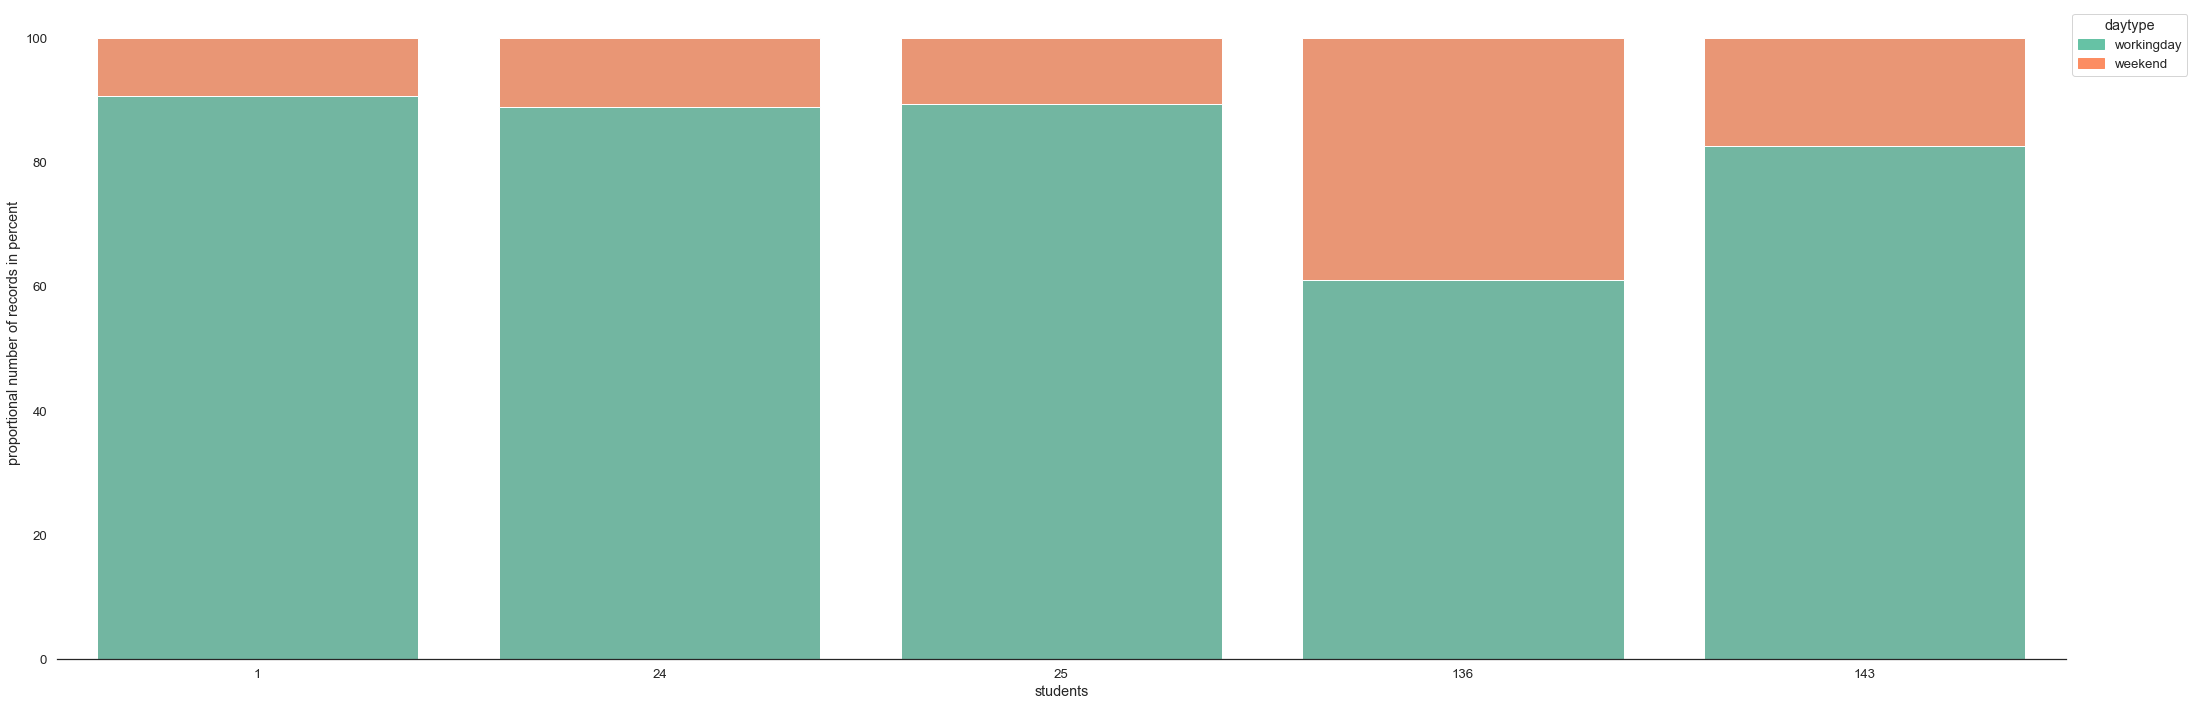

In [16]:
# Spezifische Definitionen zur Darstellung der Visualisierung
plt.figure(figsize=(36, 12))  # Größe der Visualisierung (in inch)

# Visualisierung der Gesamtmengen von Log-Einträgen pro Student und Tagestyp (in 100%)
bar_total = sns.barplot(x=loggings_daytype.index, y='total', data=loggings_daytype, color=colors_set2[1], alpha=1)
# Visualisierung der anteiligen Mengen von Log-Einträgen pro Student und Tagestyp (in x%)
bar_workingday = sns.barplot(x=loggings_daytype.index, y="workingday", data=loggings_daytype, color=colors_set2[0], alpha=1)

# weitere Anweisungen zur Darstellung der Visualisierung
bar1 = mpatches.Patch(color=colors_set2[0], label='workingday')
bar2 = mpatches.Patch(color=colors_set2[1], label='weekend')
bar_total.set_xlabel('students')
bar_total.set_ylabel('proportional number of records in percent')
plt.legend(title='daytype', handles=[bar1, bar2], bbox_to_anchor=(1, 1))
sns.despine(left=True)
# plt.savefig('charts/###.pdf', format='pdf')
plt.show()

&nbsp;
**Ausgabe der absoluten Mengen an Log-Einträgen pro Student und Tagestyp**

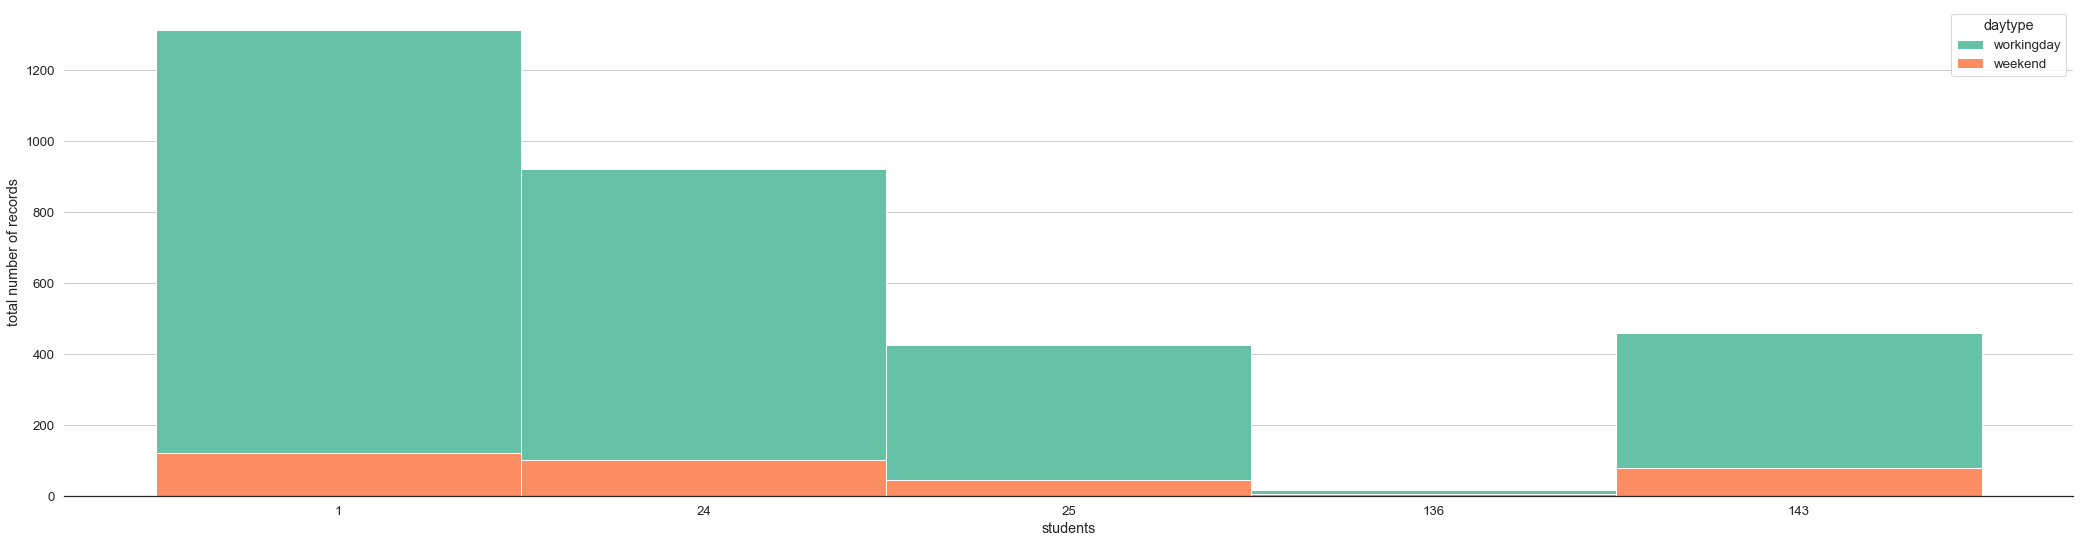

In [17]:
# Spezifische Definitionen zur Darstellung der Visualisierung
plt.figure(figsize=(36, 9)) # Größe der Visualisierung (in inch)

# Visualisierung der absoluten Mengen von Log-Einträgen pro Student und Tagestyp
chart = sns.histplot(x=md.userid[md.userstatus == 'student'].astype(str), hue=md.daytype, hue_order=['workingday', 'weekend'], multiple="stack", palette=colors_set2[0:2], alpha=1)

# weitere Anweisungen zur Darstellung der Visualisierung
chart.grid(axis='y')
chart.set_axisbelow(True)
chart.set_xlabel('students')
chart.set_ylabel('total number of records')
chart.tick_params(left=False, bottom=False)
sns.despine(left=True)
# plt.savefig('charts/###.pdf', format='pdf')
plt.show()

&nbsp;
**Typisierung der Studenten nach Lokalität ihrer Aktivitäten**

In [18]:
# Erstellung einer neuen Spalte zur Typisierung
loggings_daytype['location'] = 'workingday'
# Einordnung der Studenten nach der Lokalität ihrer Aktivitäten
loggings_daytype.loc[(loggings_daytype['workingday'] <= 50.0), ['location']] = 'weekend'
display(loggings_daytype)

loggings  total  workingday    weekend    location
userid                                                    
1           1312  100.0   90.701220   9.298780  workingday
24           923  100.0   88.949079  11.050921  workingday
25           426  100.0   89.436620  10.563380  workingday
136           18  100.0   61.111111  38.888889  workingday
143          459  100.0   82.570806  17.429194  workingday

&nbsp;
**Erstellung des neuen Datensets _loggings_daytime_1_ zur Aufnahme individueller Kennziffern**

In [19]:
# Erstellung eines neuen Datensets, bestehend aus den anteiligen Mengen an Log-Einträgen pro Student und Tageszeit
loggings_daytime_1 = pd.DataFrame()
loggings_daytime_1['loggings'] = md.timecreated[md.userstatus == 'student'].groupby(md.userid).count()
loggings_daytime_1['total'] = md.daytime_1[md.userstatus == 'student'].groupby(md.userid).count()

# Ermittlung der absoluten Mengen an Log-Einträgen pro Student und Tageszeit
loggings_daytime_1['workingtime'] = md.daytime_1[(md.userstatus == 'student') & (md.daytime_1 == 'workingtime')].groupby(md.userid).count()
loggings_daytime_1['freetime'] = md.daytime_1[(md.userstatus == 'student') & (md.daytime_1 == 'freetime')].groupby(md.userid).count()
loggings_daytime_1.fillna(value=0, inplace=True)

# Ermittlung der anteiligen Mengen an Log-Einträgen pro Student und Tageszeit (in x%)
loggings_daytime_1['workingtime'] = [i / j * 100 for i, j in zip(loggings_daytime_1['workingtime'], loggings_daytime_1['total'])]
loggings_daytime_1['freetime'] = [i / j * 100 for i, j in zip(loggings_daytime_1['freetime'], loggings_daytime_1['total'])]

# Ermittlung der anteiligen Mengen an Log-Einträgen pro Student (hier jeweils 100%)
loggings_daytime_1['total'] = [i / j * 100 for i,j in zip(loggings_daytime_1['total'], loggings_daytime_1['total'])]

display(loggings_daytime_1)

loggings  total  workingtime   freetime
userid                                         
1           1312  100.0    61.737805  38.262195
24           923  100.0    38.678223  61.321777
25           426  100.0    50.234742  49.765258
136           18  100.0    61.111111  38.888889
143          459  100.0    48.801743  51.198257

&nbsp;
**Ausgabe der anteiligen Mengen an Log-Einträgen pro Student und Tageszeit**

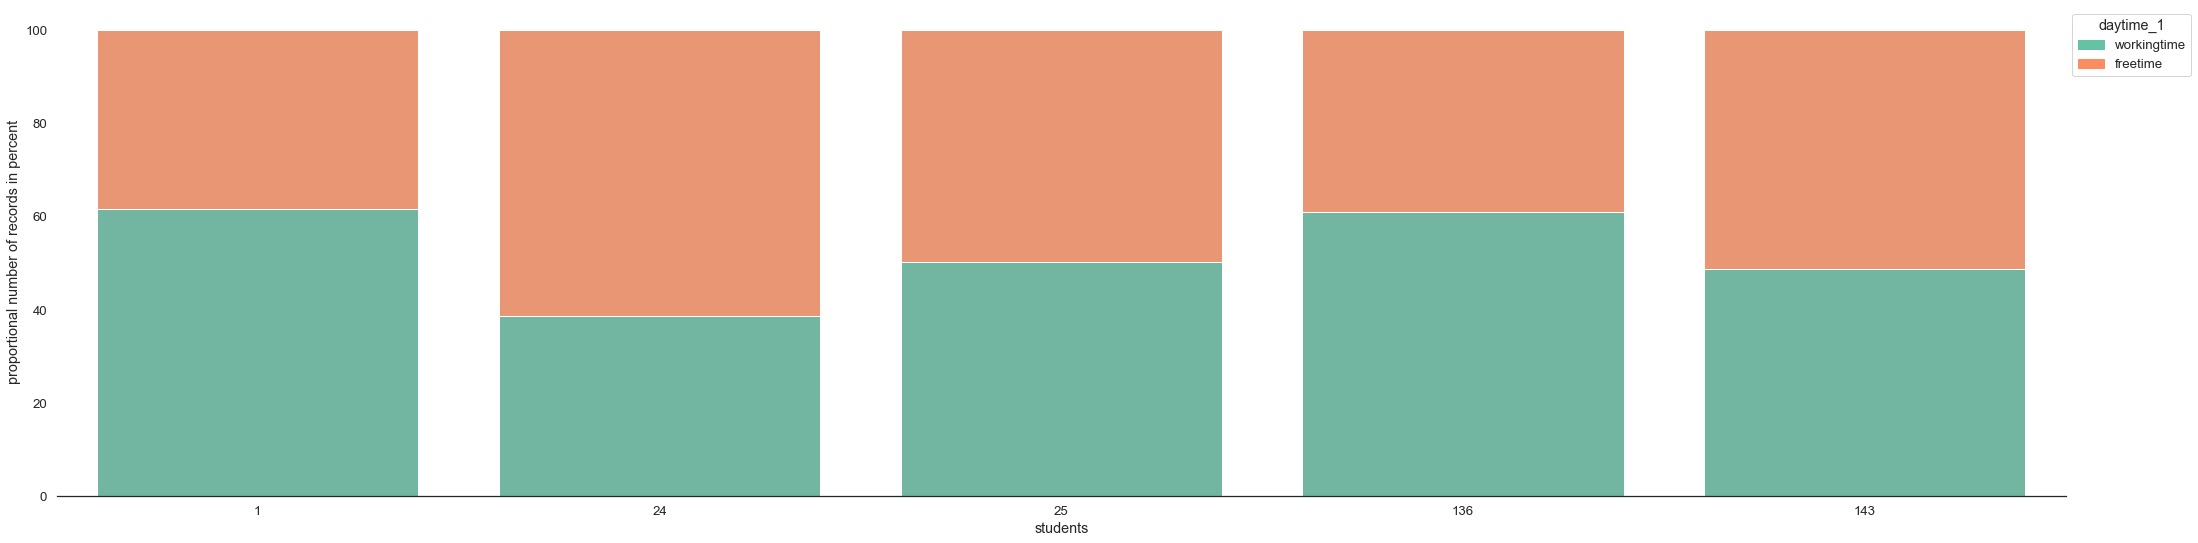

In [20]:
# Spezifische Definitionen zur Darstellung der Visualisierung
plt.figure(figsize=(36, 9))  # Größe der Visualisierung (in inch)

# Visualisierung der Gesamtmengen von Log-Einträgen pro Student und Tageszeit (in 100%)
bar_total = sns.barplot(x=loggings_daytime_1.index, y='total', data=loggings_daytime_1, color=colors_set2[1], alpha=1)
# Visualisierung der anteiligen Mengen von Log-Einträgen pro Student und Tageszeit (in x%)
bar_workingtime = sns.barplot(x=loggings_daytime_1.index, y='workingtime', data=loggings_daytime_1, color=colors_set2[0], alpha=1)

# weitere Anweisungen zur Darstellung der Visualisierung
bar1 = mpatches.Patch(color=colors_set2[0], label='workingtime')
bar2 = mpatches.Patch(color=colors_set2[1], label='freetime')
bar_total.set_xlabel('students')
bar_total.set_ylabel('proportional number of records in percent')
plt.legend(title='daytime_1', handles=[bar1, bar2], bbox_to_anchor=(1, 1))
sns.despine(left=True)
# plt.savefig('charts/###.pdf', format='pdf')
plt.show()

&nbsp;
**Ausgabe der absoluten Mengen an Log-Einträgen pro Student und Tageszeit**

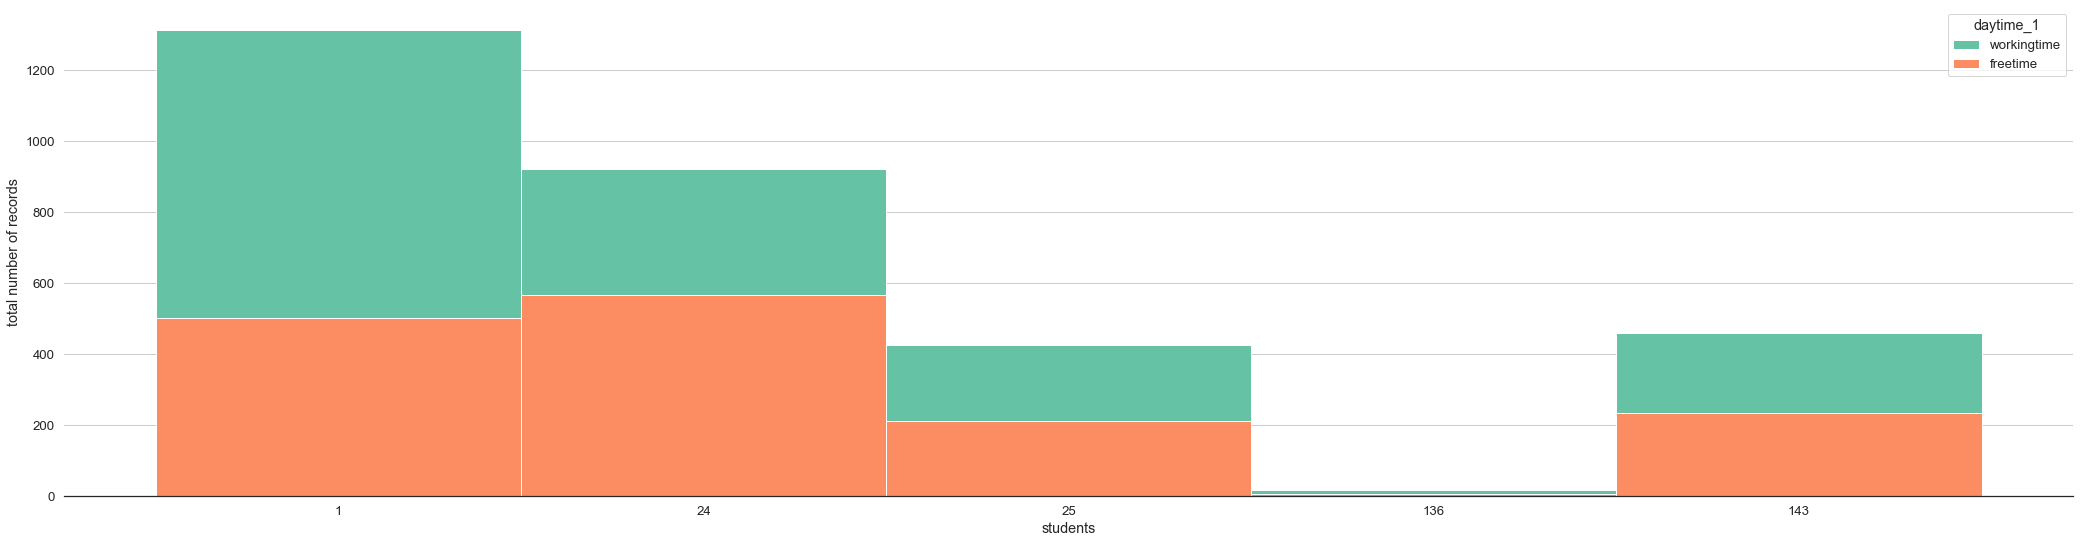

In [21]:
# Spezifische Definitionen zur Darstellung der Visualisierung
plt.figure(figsize=(36, 9)) # Größe der Visualisierung (in inch)

# Visualisierung der absoluten Mengen von Log-Einträgen pro Student und Tageszeit
chart = sns.histplot(x=md.userid[md.userstatus == 'student'].astype(str), hue=md.daytime_1, hue_order=['workingtime', 'freetime'], multiple="stack", palette=colors_set2[0:2], alpha=1)

# weitere Anweisungen zur Darstellung der Visualisierung
chart.grid(axis='y')
chart.set_axisbelow(True)
chart.set_xlabel('students')
chart.set_ylabel('total number of records')
chart.tick_params(left=False, bottom=False)
sns.despine(left=True)
# plt.savefig('charts/###.pdf', format='pdf')
plt.show()

&nbsp;
**Typisierung der Studenten nach Lokalität ihrer Aktivitäten**

In [22]:
# Erstellung einer neuen Spalte zur Typisierung
loggings_daytime_1['location'] = 'workingtime'
# Einordnung der Studenten nach der Lokalität ihrer Aktivitäten
loggings_daytime_1.loc[(loggings_daytime_1['workingtime'] <= 50.0), ['location']] = 'freetime'
display(loggings_daytime_1)

loggings  total  workingtime   freetime     location
userid                                                      
1           1312  100.0    61.737805  38.262195  workingtime
24           923  100.0    38.678223  61.321777     freetime
25           426  100.0    50.234742  49.765258  workingtime
136           18  100.0    61.111111  38.888889  workingtime
143          459  100.0    48.801743  51.198257     freetime

&nbsp;
**Erstellung des neuen Datensets _loggings_daytime_2_ zur Aufnahme individueller Kennziffern**

In [23]:
# Erstellung eines neuen Datensets, bestehend aus den anteiligen Mengen an Log-Einträgen pro Student und Tageszeit
loggings_daytime_2 = pd.DataFrame()
loggings_daytime_2['loggings'] = md.timecreated[md.userstatus == 'student'].groupby(md.userid).count()
loggings_daytime_2['total'] = md.daytime_2[md.userstatus == 'student'].groupby(md.userid).count()

# Ermittlung der absoluten Mengen an Log-Einträgen pro Student und Tageszeit
loggings_daytime_2['night'] = md.daytime_2[(md.userstatus == 'student') & (md.daytime_2 == 'night')].groupby(md.userid).count()
loggings_daytime_2['morning'] = md.daytime_2[(md.userstatus == 'student') & (md.daytime_2 == 'morning')].groupby(md.userid).count()
loggings_daytime_2['afternoon'] = md.daytime_2[(md.userstatus == 'student') & (md.daytime_2 == 'afternoon')].groupby(md.userid).count()
loggings_daytime_2['evening'] = md.daytime_2[(md.userstatus == 'student') & (md.daytime_2 == 'evening')].groupby(md.userid).count()
loggings_daytime_2.fillna(value=0, inplace=True)

# Ermittlung der anteiligen Mengen an Log-Einträgen pro Student und Tageszeit (in x%)
loggings_daytime_2['night'] = [i / j * 100 for i, j in zip(loggings_daytime_2['night'], loggings_daytime_2['total'])]
loggings_daytime_2['morning'] = [i / j * 100 for i, j in zip(loggings_daytime_2['morning'], loggings_daytime_2['total'])]
loggings_daytime_2['afternoon'] = [i / j * 100 for i, j in zip(loggings_daytime_2['afternoon'], loggings_daytime_2['total'])] # nicht aufsummiert
loggings_daytime_2['evening'] = [i / j * 100 for i, j in zip(loggings_daytime_2['evening'], loggings_daytime_2['total'])] # nicht aufsummiert

# Ermittlung der anteiligen Mengen an Log-Einträgen pro Student (hier jeweils 100%)
loggings_daytime_2['total'] = [i / j * 100 for i,j in zip(loggings_daytime_2['total'], loggings_daytime_2['total'])]

display(loggings_daytime_2)

loggings  total      night    morning  afternoon    evening
userid                                                             
1           1312  100.0   5.259146  30.030488  38.033537  26.676829
24           923  100.0  11.484290  19.826652  23.726977  44.962080
25           426  100.0  18.075117  32.159624  18.779343  30.985915
136           18  100.0   0.000000  94.444444   5.555556   0.000000
143          459  100.0   0.000000  12.418301  37.472767  50.108932

&nbsp;
**Ausgabe der anteiligen Mengen an Log-Einträgen pro Student und Tageszeit**

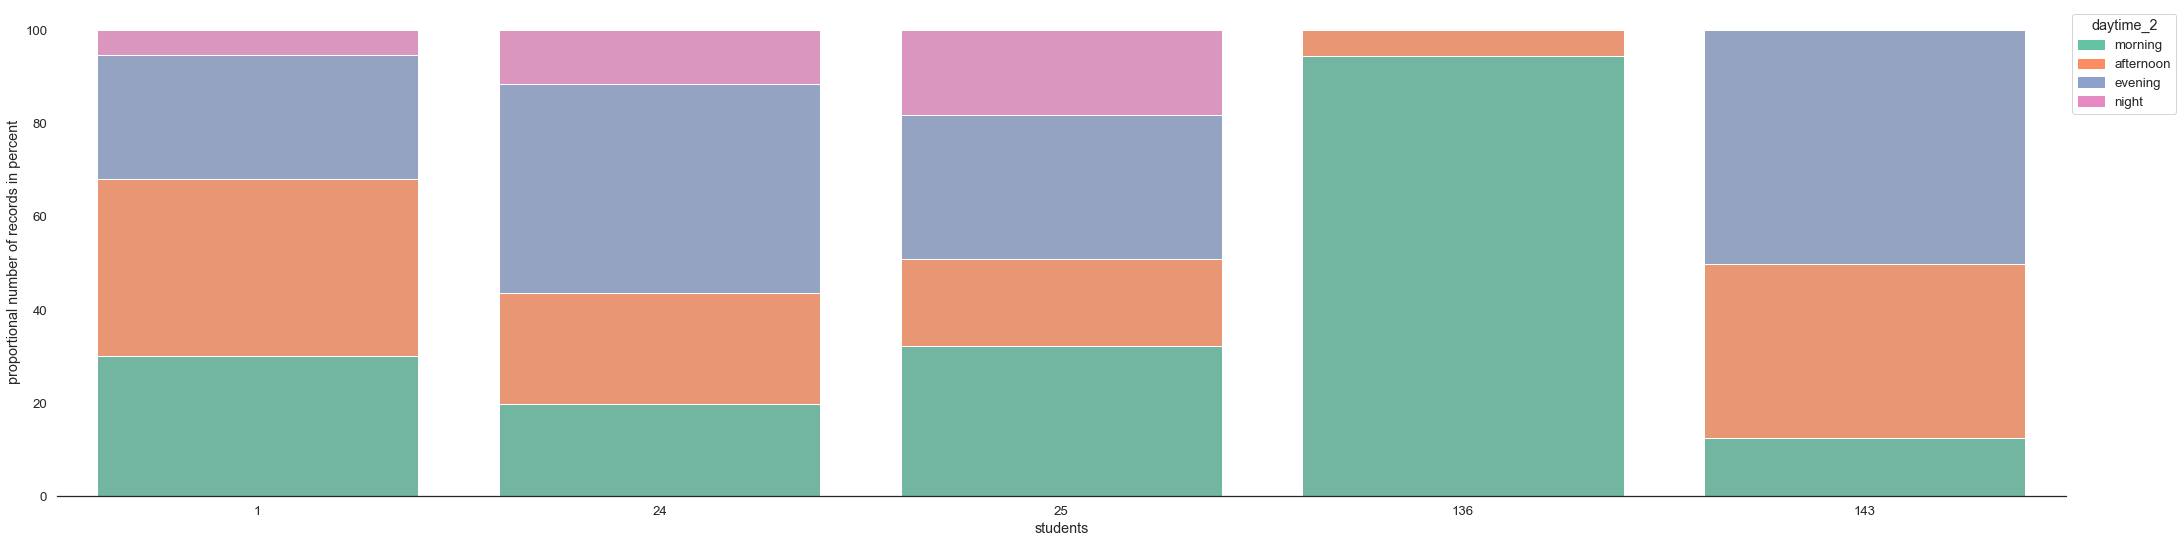

In [24]:
# Spezifische Definitionen zur Darstellung der Visualisierung
plt.figure(figsize=(36, 9))  # Größe der Visualisierung (in inch)

# Visualisierung der Gesamtmengen von Log-Einträgen pro Student und Tageszeit (in 100%)
bar_total = sns.barplot(x=loggings_daytime_2.index, y='total', data=loggings_daytime_2, color=colors_set2[3], alpha=1)
# Visualisierung der anteiligen Mengen von Log-Einträgen pro Student und Tagestyp (in x%)
bar_evening = sns.barplot(x=loggings_daytime_2.index, y=loggings_daytime_2.morning+loggings_daytime_2.afternoon+loggings_daytime_2.evening, data=loggings_daytime_2, color=colors_set2[2], alpha=1)
bar_afternoon = sns.barplot(x=loggings_daytime_2.index, y=loggings_daytime_2.morning+loggings_daytime_2.afternoon, data=loggings_daytime_2, color=colors_set2[1], alpha=1)
bar_morning = sns.barplot(x=loggings_daytime_2.index, y='morning', data=loggings_daytime_2, color=colors_set2[0], alpha=1)

# weitere Anweisungen zur Darstellung der Visualisierung
bar1 = mpatches.Patch(color=colors_set2[0], label='morning')
bar2 = mpatches.Patch(color=colors_set2[1], label='afternoon')
bar3 = mpatches.Patch(color=colors_set2[2], label='evening')
bar4 = mpatches.Patch(color=colors_set2[3], label='night')
bar_total.set_xlabel('students')
bar_total.set_ylabel('proportional number of records in percent')
plt.legend(title='daytime_2', handles=[bar1, bar2, bar3, bar4], bbox_to_anchor=(1, 1))
sns.despine(left=True)
# plt.savefig('charts/###.pdf', format='pdf')
plt.show()

&nbsp;
**Ausgabe der absoluten Mengen an Log-Einträgen pro Student und Tageszeit**

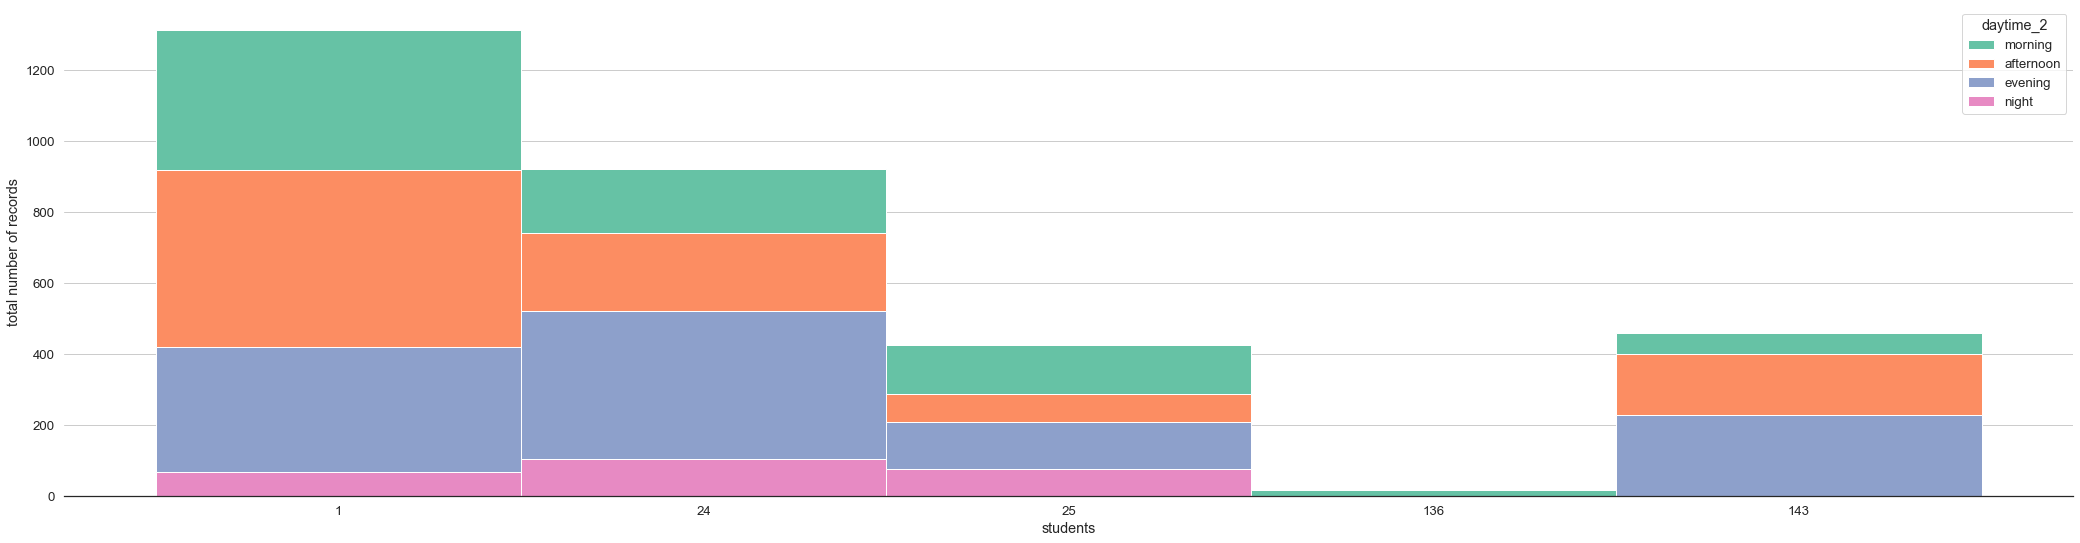

In [25]:
# Spezifische Definitionen zur Darstellung der Visualisierung
plt.figure(figsize=(36, 9)) # Größe der Visualisierung (in inch)

# Visualisierung der absoluten Mengen von Log-Einträgen pro Student und Tageszeit
chart = sns.histplot(x=md.userid[md.userstatus == 'student'].astype(str), hue=md.daytime_2, hue_order=['morning', 'afternoon', 'evening', 'night'], multiple="stack", palette=colors_set2[0:4], alpha=1)

# weitere Anweisungen zur Darstellung der Visualisierung
chart.grid(axis='y')
chart.set_axisbelow(True)
chart.set_xlabel('students')
chart.set_ylabel('total number of records')
chart.tick_params(left=False, bottom=False)
sns.despine(left=True)
# plt.savefig('charts/###.pdf', format='pdf')
plt.show()

&nbsp;
**Typisierung der Studenten nach Lokalität ihrer Aktivitäten**

In [26]:
# Erstellung einer neuen Spalte zur Typisierung
loggings_daytime_2['location'] = 'night'
# Einordnung der Studenten nach der Lokalität ihrer Aktivitäten
loggings_daytime_2.loc[((loggings_daytime_2['morning'] > loggings_daytime_2['afternoon']) & (loggings_daytime_2['morning'] > loggings_daytime_2['evening'])), ['location']] = 'morning'
loggings_daytime_2.loc[((loggings_daytime_2['afternoon'] > loggings_daytime_2['morning']) & (loggings_daytime_2['afternoon'] > loggings_daytime_2['evening'])), ['location']] = 'afternoon'
loggings_daytime_2.loc[((loggings_daytime_2['evening'] > loggings_daytime_2['morning']) & (loggings_daytime_2['evening'] > loggings_daytime_2['afternoon'])), ['location']] = 'evening'
display(loggings_daytime_2)

loggings  total      night    morning  afternoon    evening   location
userid                                                                        
1           1312  100.0   5.259146  30.030488  38.033537  26.676829  afternoon
24           923  100.0  11.484290  19.826652  23.726977  44.962080    evening
25           426  100.0  18.075117  32.159624  18.779343  30.985915    morning
136           18  100.0   0.000000  94.444444   5.555556   0.000000    morning
143          459  100.0   0.000000  12.418301  37.472767  50.108932    evening

&nbsp;
#### Anwendung der Unterscheidungskriterien

&nbsp;
**Typisierung der Studenten nach Höhe der anteiligen Menge an Log-Einträgen pro Tagestyp**

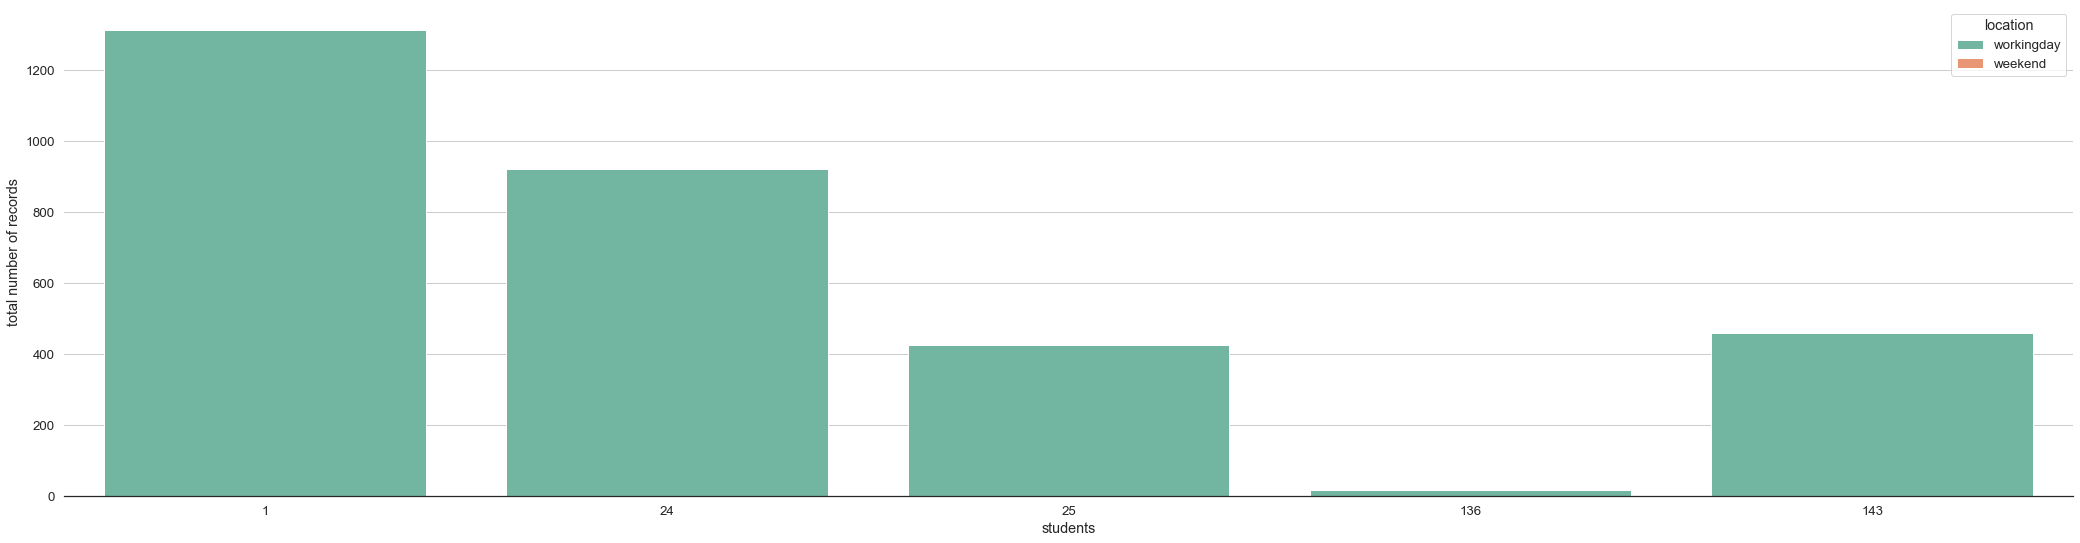

In [27]:
# Spezifische Definitionen zur Darstellung der Visualisierung
plt.figure(figsize=(36, 9)) # Größe der Visualisierung (in inch)

# Visualisierung der Typisierung der Studenten nach Tagestyp
chart = sns.barplot(x=loggings_daytype.index, y=loggings_daytype.loggings, hue=loggings_daytype.location, hue_order=['workingday', 'weekend'], dodge=False, palette='Set2')

# weitere Anweisungen zur Darstellung der Visualisierung
chart.grid(axis='y')
chart.set_axisbelow(True)
chart.set_xlabel('students')
chart.set_ylabel('total number of records')
chart.tick_params(left=False, bottom=False)
sns.despine(left=True)
plt.legend(title='location', loc='upper right')
# plt.savefig('charts/###.pdf', format='pdf')
plt.show()

&nbsp;
**Typisierung der Studenten nach Höhe der anteiligen Menge an Log-Einträgen pro Tageszeit**

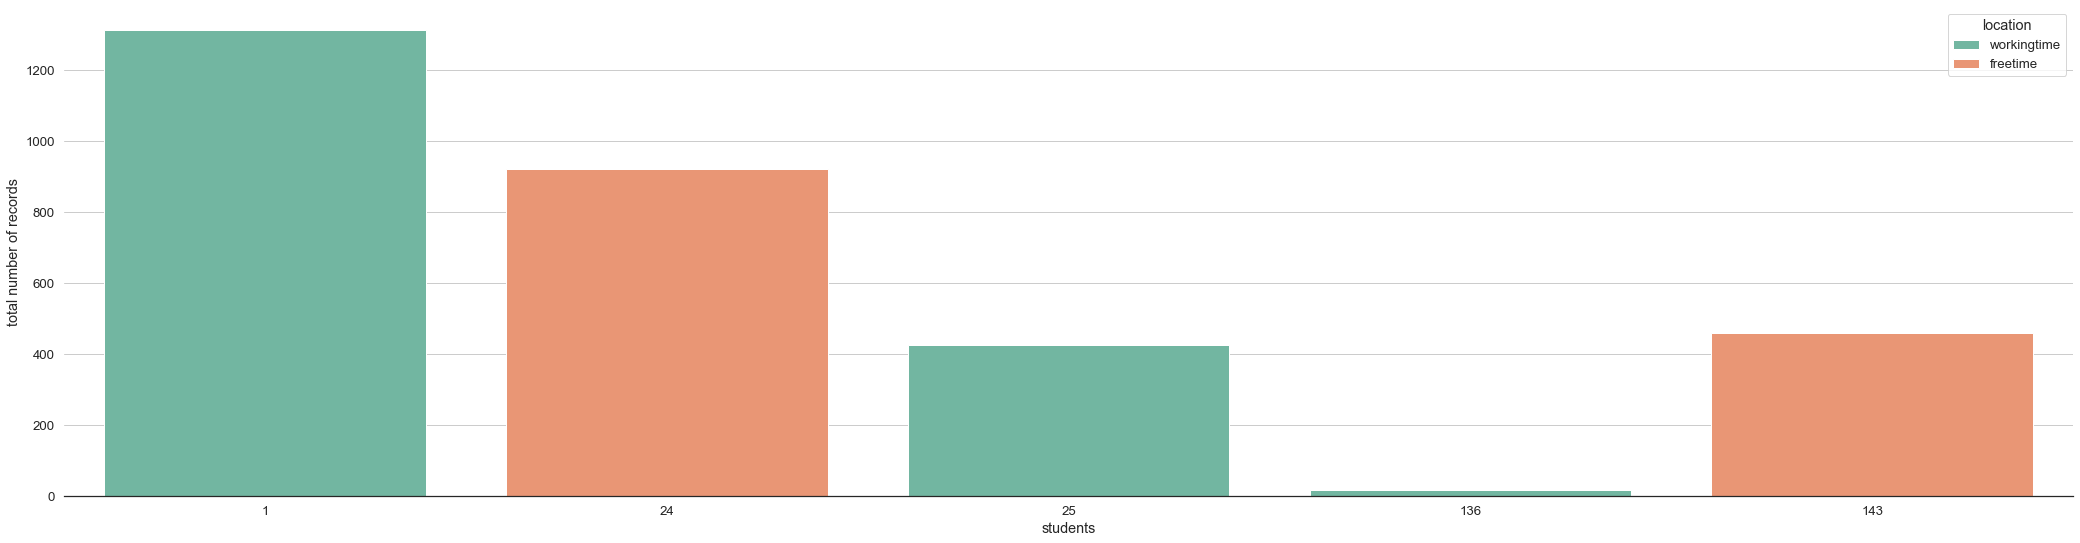

In [28]:
# Spezifische Definitionen zur Darstellung der Visualisierung
plt.figure(figsize=(36, 9)) # Größe der Visualisierung (in inch)

# Visualisierung der Typisierung der Studenten nach Tagestyp
chart = sns.barplot(x=loggings_daytime_1.index, y=loggings_daytime_1.loggings, hue=loggings_daytime_1.location, hue_order=['workingtime', 'freetime'], dodge=False, palette='Set2')

# weitere Anweisungen zur Darstellung der Visualisierung
chart.grid(axis='y')
chart.set_axisbelow(True)
chart.set_xlabel('students')
chart.set_ylabel('total number of records')
chart.tick_params(left=False, bottom=False)
sns.despine(left=True)
plt.legend(title='location', loc='upper right')
# plt.savefig('charts/###.pdf', format='pdf')
plt.show()

&nbsp;
**Typisierung der Studenten nach Höhe der anteiligen Menge an Log-Einträgen pro Tageszeit**

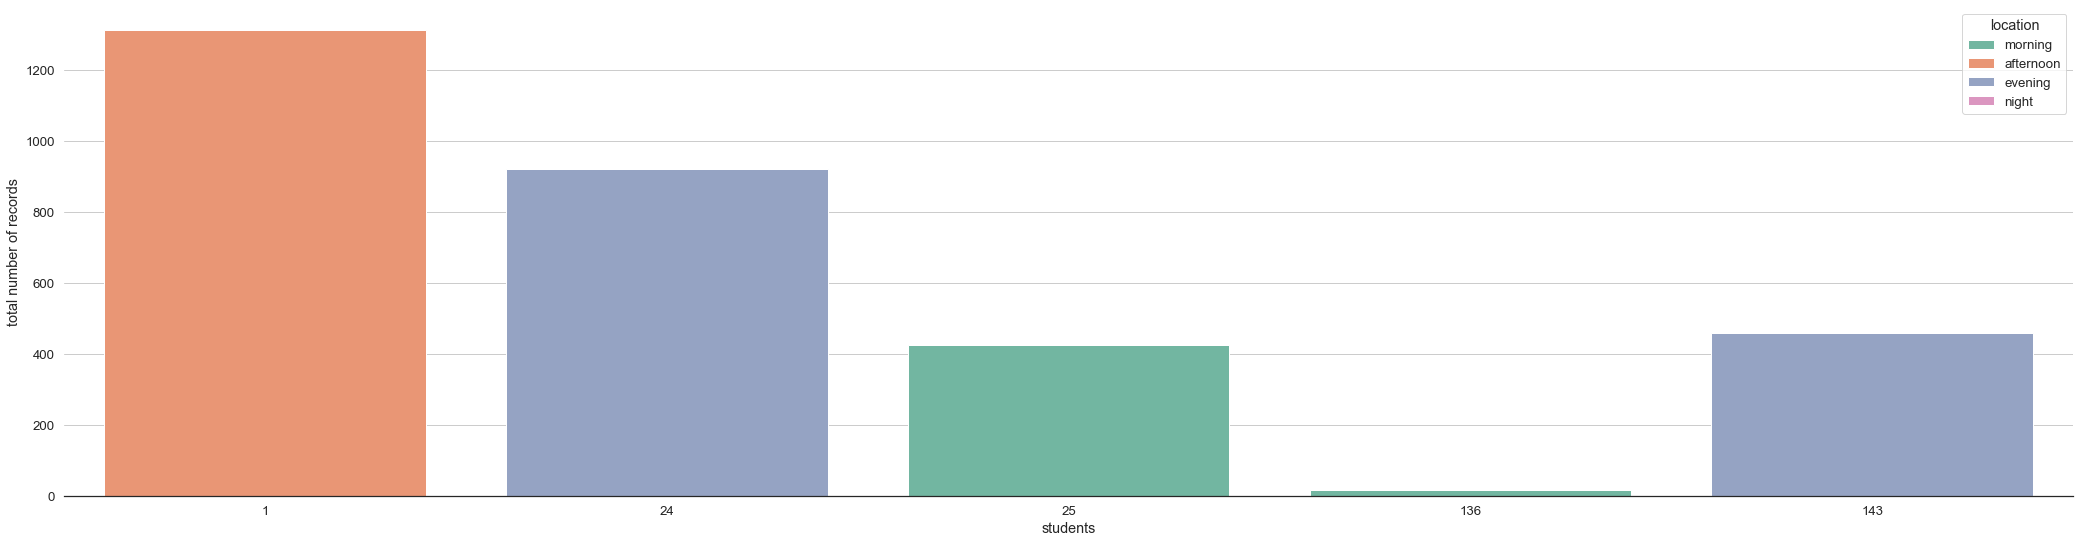

In [29]:
# Spezifische Definitionen zur Darstellung der Visualisierung
plt.figure(figsize=(36, 9)) # Größe der Visualisierung (in inch)

# Visualisierung der Typisierung der Studenten nach Tagestyp
chart = sns.barplot(x=loggings_daytime_2.index, y=loggings_daytime_2.loggings, hue=loggings_daytime_2.location, hue_order=['morning', 'afternoon', 'evening', 'night'], dodge=False, palette='Set2')

# weitere Anweisungen zur Darstellung der Visualisierung
chart.grid(axis='y')
chart.set_axisbelow(True)
chart.set_xlabel('students')
chart.set_ylabel('total number of records')
chart.tick_params(left=False, bottom=False)
sns.despine(left=True)
plt.legend(title='location', loc='upper right')
# plt.savefig('charts/###.pdf', format='pdf')
plt.show()